In [1]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer, OrdinalEncoder, StandardScaler

In [2]:
PATH = './Data/Raw/'

In [3]:
files = os.listdir(PATH)

pbp_df = pd.DataFrame()
for file in files:
    temp_df = pd.read_csv(PATH + file, on_bad_lines = 'skip')
    temp_df['File'] = file[4:8] # to be able to filter data later on by file 
    pbp_df = pd.concat([pbp_df,temp_df])

C:\Users\Lucas\AppData\Local\Temp\ipykernel_9240\540912557.py:5: DtypeWarning: Columns (15,33) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(PATH + file, on_bad_lines = 'skip')


In [4]:
print(F'Data of {pbp_df["GameId"].nunique()} individual Games.')

print(F'''
Shape: {pbp_df.shape}
      
Columns:
{pbp_df.columns.tolist()}''')

print(F"""
Missing:
{pbp_df.isnull().mean().mul(100).sort_values(ascending = False).round(2).astype(str) + '%'}    
""")

Data of 2494 individual Games.

Shape: (445983, 46)
      
Columns:
['GameId', 'GameDate', 'Quarter', 'Minute', 'Second', 'OffenseTeam', 'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'Unnamed: 10', 'SeriesFirstDown', 'Unnamed: 12', 'NextScore', 'Description', 'TeamWin', 'Unnamed: 16', 'Unnamed: 17', 'SeasonYear', 'Yards', 'Formation', 'PlayType', 'IsRush', 'IsPass', 'IsIncomplete', 'IsTouchdown', 'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed', 'Challenger', 'IsMeasurement', 'IsInterception', 'IsFumble', 'IsPenalty', 'IsTwoPointConversion', 'IsTwoPointConversionSuccessful', 'RushDirection', 'YardLineFixed', 'YardLineDirection', 'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay', 'PenaltyType', 'PenaltyYards', 'File']

Missing:
Unnamed: 10                       100.0%
Unnamed: 12                       100.0%
Challenger                        100.0%
Unnamed: 17                       100.0%
Unnamed: 16                       100.0%
PenaltyTeam                       91.86%
PenaltyType  

In [5]:
# drop unnecessary columns
pbp_df = pbp_df.drop(labels = ['Unnamed: 12', 'Unnamed: 10', 'Unnamed: 16', 'Unnamed: 17', 'Challenger'], axis = 1)

In [6]:
# show how many points of data are available for every team per year
pbp_df.groupby(['OffenseTeam', 'File']).size().mean() 

1287.20625

In [7]:
pbp_df['PlayType'].unique()

array([nan, 'EXCEPTION', 'TIMEOUT', 'KICK OFF', 'QB KNEEL', 'PASS',
       'SACK', 'RUSH', 'CLOCK STOP', 'PUNT', 'EXTRA POINT', 'NO PLAY',
       'FIELD GOAL', 'SCRAMBLE', 'FUMBLES', 'TWO-POINT CONVERSION',
       'PENALTY', '0'], dtype=object)

In [8]:
#create GameTime feature to sort by
pbp_df['GameTime'] = (pbp_df['Quarter'] - 1) *15 - pbp_df['Minute'] + 15 + (- pbp_df['Second'] + 60)*0.016

In [9]:
pbp_df= pbp_df.sort_values(by = ['GameId','GameTime'])
pbp_df.reset_index(drop=True, inplace = True)

In [10]:
# create driveID
pbp_df['DriveId'] = ~ (pbp_df['OffenseTeam'] == pbp_df['OffenseTeam'].shift(1))
pbp_df['DriveId'] = pbp_df['DriveId'].cumsum()

pbp_df['DriveId'] = pbp_df.groupby('GameId')['DriveId'].transform(lambda x: pd.factorize(x)[0])

In [11]:
# add points feature
# a touchdown gets the offensive team 6 points if it is not an interception and not nullified 
pbp_df.loc[pbp_df['Description'].str.contains('TOUCHDOWN', na = False) &
           ~ pbp_df['Description'].str.contains('INTERCEPTED', na = False) &
           ~ pbp_df['Description'].str.contains('FUMBLES', na = False) &
           ~ pbp_df['Description'].str.contains('NULLIFIED', na = False), 
           'OffensePoints'] = 6

# if a the word touchdown occurs before the word reversed it was no touchdown and should give no points
pbp_df.loc[pbp_df['Description'].str.find('TOUCHDOWN') < pbp_df['Description'].str.find('REVERSED'),
          'OffensePoints'] = 0 

# a field goal gets the offensive team 3 points
pbp_df.loc[pbp_df['Description'].str.contains('FIELD GOAL IS GOOD', na = False) &
           ~ pbp_df['Description'].str.contains('NULLIFIED', na = False), 'OffensePoints'] = 3

# an extra point gets the offensive team 3 points
pbp_df.loc[pbp_df['Description'].str.contains('EXTRA POINT IS GOOD', na = False) &
           ~ pbp_df['Description'].str.contains('REVERSED', na = False), 'OffensePoints'] = 1

# a two point attempt gives two points
pbp_df.loc[pbp_df['Description'].str.contains('ATTEMPT SUCCEEDS', na = False), 'OffensePoints'] = 2
pbp_df.loc[pbp_df['Description'].str.find('ATTEMPT SUCCEEDS') < pbp_df['Description'].str.find('REVERSED'),
          'OffensePoints'] = 0 

# a safety gives the defense two points
pbp_df.loc[pbp_df['Description'].str.contains('SAFETY', na = False), 'DefensePoints'] = 2

# interceptions to touchdown for defense
pbp_df.loc[pbp_df['Description'].str.contains('INTERCEPTED', na = False) &
           pbp_df['Description'].str.contains('TOUCHDOWN', na = False) &
           ~ pbp_df['Description'].str.contains('NULLIFIED', na = False) &
           (pbp_df['Description'].str.rfind('TOUCHDOWN') > pbp_df['Description'].str.rfind('REVERSED')),
           'DefensePoints'] = 6

# fumbles to touchdown for defense

In [12]:
#add points per team up
pbp_df['OffensePoints'].fillna(0, inplace = True)
pbp_df['DefensePoints'].fillna(0, inplace = True)

In [13]:
for g_id, game in tqdm(pbp_df.groupby('GameId')):
    first = True
    for idx, row in game.iterrows():
        
        #skip first row
        if first:
            first = False
            continue
            
        prev = pbp_df.iloc[idx - 1].copy() # get previous row
        
        if (prev['OffenseTeam'] != row['OffenseTeam']) & pd.notnull(prev['OffenseTeam']) & pd.notnull(row['OffenseTeam']):
            pbp_df.loc[idx, 'OffensePoints'] = prev['DefensePoints'] + row['OffensePoints']
            pbp_df.loc[idx, 'DefensePoints'] = prev['OffensePoints'] + row['DefensePoints']
        
        else:
            pbp_df.loc[idx, 'OffensePoints'] = prev['OffensePoints'] + row['OffensePoints']
            pbp_df.loc[idx, 'DefensePoints'] = prev['DefensePoints'] + row['DefensePoints']

100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [13:27<00:00,  3.09it/s]


In [14]:
pbp_df['PointDifference'] = pbp_df['OffensePoints'] - pbp_df['DefensePoints']

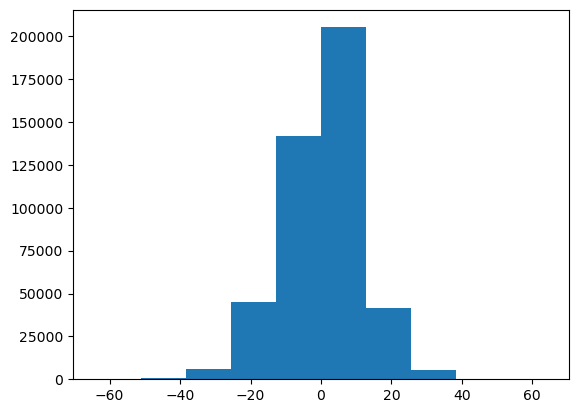

In [15]:
plt.hist(pbp_df['PointDifference'])
plt.show()

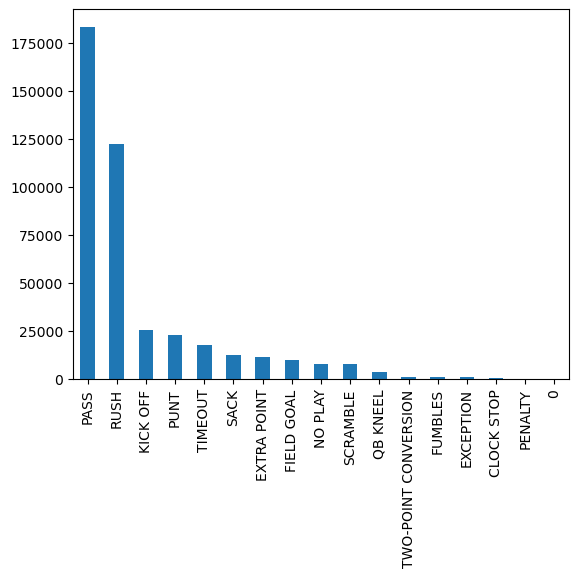

In [16]:
pbp_df['PlayType'].value_counts().plot(kind = 'bar')
plt.show()

In [17]:
# reduce down to relevant play types
pbp_df = pbp_df.loc[pbp_df['PlayType'].isin(['PASS','RUSH'])]

In [18]:
pbp_df['Formation'].unique()

array(['UNDER CENTER', 'SHOTGUN', 'NO HUDDLE SHOTGUN', 'NO HUDDLE',
       'WILDCAT', 'FIELD GOAL', 'PUNT'], dtype=object)

<Axes: >

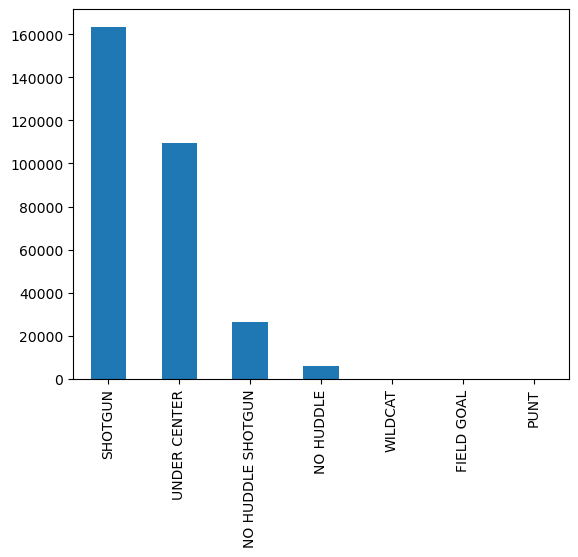

In [19]:
pbp_df['Formation'].value_counts().plot(kind = 'bar')

In [20]:
pbp_df = pbp_df.loc[pbp_df['Formation'].isin(['UNDER CENTER', 'NO HUDDLE', 'SHOTGUN', 'NO HUDDLE SHOTGUN'])]

In [21]:
pd.set_option('display.max_columns', 500)
pbp_df.describe()

,GameId,Quarter,Minute,Second,Down,ToGo,YardLine,SeriesFirstDown,NextScore,SeasonYear,Yards,IsRush,IsPass,IsIncomplete,IsTouchdown,IsSack,IsChallenge,IsChallengeReversed,IsMeasurement,IsInterception,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,YardLineFixed,IsPenaltyAccepted,IsNoPlay,PenaltyYards,GameTime,DriveId,OffensePoints,DefensePoints,PointDifference
count,3.056990e+05,305699.000000,305699.000000,305699.000000,305699.000000,305699.000000,305699.000000,305699.000000,305699.0,305699.000000,305699.000000,305699.000000,305699.000000,305699.000000,305699.000000,305699.0,305699.000000,305699.000000,305699.0,305699.000000,305699.000000,305699.0,305699.0,305699.000000,305699.000000,305699.000000,305699.000000,305699.000000,305699.000000,305699.000000,305699.000000,305699.000000
mean,2.017480e+09,2.554460,6.775335,28.568530,1.777991,8.573531,48.460309,0.286645,0.0,2017.352278,6.163707,0.399975,0.600025,0.214011,0.042454,0.0,0.006035,0.002509,0.0,0.014809,0.067727,0.0,0.0,28.767585,0.056425,0.043252,0.561314,32.044475,23.076677,10.479714,11.383766,-0.904053
std,2.846137e+06,1.129699,4.512713,17.746277,0.815478,3.955226,24.774603,0.452195,0.0,2.850958,8.964792,0.489894,0.489894,0.410135,0.201622,0.0,0.077453,0.050027,0.0,0.120787,0.251277,0.0,0.0,12.858255,0.230741,0.203424,2.739011,17.596895,15.426435,9.482504,9.815067,10.444171
min,2.013090e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2013.000000,-26.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.960000,0.000000,0.000000,0.000000,-64.000000
25%,2.015103e+09,2.000000,3.000000,13.000000,1.000000,6.000000,27.000000,0.000000,0.0,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,20.000000,0.000000,0.000000,0.000000,17.128000,9.000000,3.000000,3.000000,-7.000000
50%,2.017121e+09,3.000000,7.000000,28.000000,2.000000,10.000000,45.000000,0.000000,0.0,2017.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,29.000000,0.000000,0.000000,0.000000,30.960000,24.000000,9.000000,10.000000,0.000000
75%,2.020102e+09,4.000000,11.000000,44.000000,2.000000,10.000000,68.000000,1.000000,0.0,2020.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,40.000000,0.000000,0.000000,0.000000,47.192000,35.000000,17.000000,17.000000,5.000000
max,2.022122e+09,5.000000,15.000000,59.000000,4.000000,48.000000,100.000000,1.000000,0.0,2022.000000,104.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,0.0,0.0,50.000000,1.000000,1.000000,66.000000,75.944000,87.000000,67.000000,67.000000,64.000000


In [22]:
pbp_df['Down'].value_counts()

1    138018
2    102512
3     60112
4      5038
0        19
Name: Down, dtype: int64

In [23]:
pbp_df = pbp_df.loc[pbp_df['Down'] != 0] # get rid of 0 Down Situations

<Axes: >

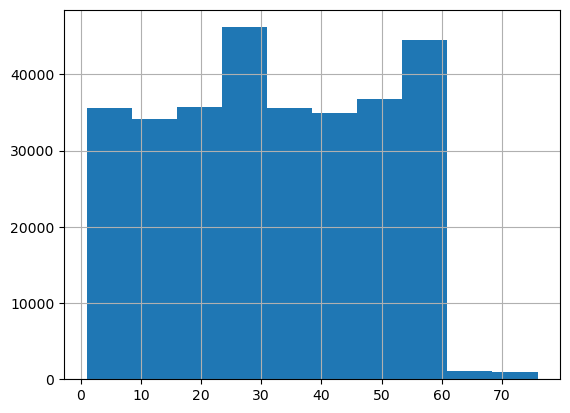

In [24]:
pbp_df['GameTime'].hist()

In [25]:
n_previous = 3

for i in range(n_previous):
    if i > 0:
        name = 'PreviousPlay' + str(i + 1)
    else:
        name = 'PreviousPlay'
    
    pbp_df.loc[pbp_df['OffenseTeam'] == pbp_df['OffenseTeam'].shift(i + 1), name] = pbp_df['PlayType'].shift(i + 1)
    pbp_df.loc[pbp_df[name].isna(), name] = 'NoPlay' 

In [29]:
pbp_df

,index,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,NextScore,Description,TeamWin,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,File,GameTime,DriveId,OffensePoints,DefensePoints,PointDifference,PreviousPlay,PreviousPlay2,PreviousPlay3,index,NO HUDDLE,NO HUDDLE SHOTGUN,SHOTGUN,UNDER CENTER
0,1,2013090500,2013-09-05,1,15,0,BAL,DEN,1,10,20,0,0,(15:00) 5-J.FLACCO PASS SHORT MIDDLE TO 27-R.R...,0,2013,-1,UNDER CENTER,PASS,0,1,0.0,0,SHORT MIDDLE,0,0,0,0.0,0,0,0,0.0,0,NaN,20,OWN,0.0,NaN,0.0,NaN,0.0,2013,0.960,1,0.0,0.0,0.0,NoPlay,NoPlay,NoPlay,0,0,0,0,1
1,2,2013090500,2013-09-05,1,14,14,BAL,DEN,2,11,19,0,0,(14:14) 27-R.RICE LEFT TACKLE TO BAL 22 FOR 3 ...,0,2013,3,UNDER CENTER,RUSH,1,0,0.0,0,NaN,0,0,0,0.0,0,0,0,0.0,0,LEFT TACKLE,19,OWN,0.0,NaN,0.0,NaN,0.0,2013,1.736,1,0.0,0.0,0.0,PASS,NoPlay,NoPlay,1,0,0,0,1
2,3,2013090500,2013-09-05,1,13,38,BAL,DEN,3,8,22,0,0,(13:38) (SHOTGUN) 5-J.FLACCO PASS SHORT LEFT T...,0,2013,6,SHOTGUN,PASS,0,1,0.0,0,SHORT LEFT,0,0,0,0.0,0,0,1,0.0,0,NaN,22,OWN,0.0,BAL,0.0,OFFENSIVE PASS INTERFERENCE,0.0,2013,2.352,1,0.0,0.0,0.0,RUSH,PASS,NoPlay,2,0,0,1,0
3,5,2013090500,2013-09-05,1,13,10,DEN,BAL,1,10,23,0,0,(13:10) (SHOTGUN) 18-P.MANNING PASS INCOMPLETE...,0,2013,0,SHOTGUN,PASS,0,1,1.0,0,SHORT RIGHT,0,0,0,0.0,0,0,0,0.0,0,NaN,23,OWN,0.0,NaN,0.0,NaN,0.0,2013,2.800,2,0.0,0.0,0.0,NoPlay,NoPlay,NoPlay,3,0,0,1,0
4,6,2013090500,2013-09-05,1,13,5,DEN,BAL,2,10,23,0,0,"(13:05) (NO HUDDLE, SHOTGUN) 27-K.MORENO RIGHT...",0,2013,1,NO HUDDLE SHOTGUN,RUSH,1,0,0.0,0,NaN,0,0,0,0.0,0,0,0,0.0,0,RIGHT GUARD,23,OWN,0.0,NaN,0.0,NaN,0.0,2013,2.880,2,0.0,0.0,0.0,PASS,NoPlay,NoPlay,4,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305675,445976,2022121808,2022-12-18,4,0,25,NE,LV,2,2,33,0,0,(:25) (SHOTGUN) 10-M.JONES PASS INCOMPLETE SHO...,0,2022,0,SHOTGUN,PASS,0,1,1.0,0,SHORT LEFT,0,0,0,0.0,0,0,0,0.0,0,NaN,33,OWN,0.0,NaN,0.0,NaN,0.0,2022,60.560,53,38.0,10.0,28.0,PASS,NoPlay,NoPlay,305675,0,0,1,0
305676,445977,2022121808,2022-12-18,4,0,20,NE,LV,3,2,33,1,0,(:20) (SHOTGUN) 38-R.STEVENSON UP THE MIDDLE T...,0,2022,12,SHOTGUN,RUSH,1,0,0.0,0,NaN,0,0,0,0.0,0,0,0,0.0,0,CENTER,33,OWN,0.0,NaN,0.0,NaN,0.0,2022,60.640,53,38.0,10.0,28.0,PASS,PASS,NoPlay,305676,0,0,1,0
305677,445979,2022121808,2022-12-18,4,0,14,NE,LV,1,10,45,0,0,(:14) (SHOTGUN) 10-M.JONES PASS INCOMPLETE SHO...,0,2022,0,SHOTGUN,PASS,0,1,1.0,0,SHORT RIGHT,0,0,0,0.0,0,0,0,0.0,0,NaN,45,OWN,0.0,NaN,0.0,NaN,0.0,2022,60.736,55,38.0,10.0,28.0,RUSH,PASS,PASS,305677,0,0,1,0
305678,445980,2022121808,2022-12-18,4,0,10,NE,LV,2,10,45,0,0,(:10) (SHOTGUN) 10-M.JONES PASS INCOMPLETE DEE...,0,2022,0,SHOTGUN,PASS,0,1,1.0,0,DEEP RIGHT,0,0,0,0.0,0,0,0,0.0,0,NaN,45,OWN,0.0,NaN,0.0,NaN,0.0,2022,60.800,55,38.0,10.0,28.0,PASS,RUSH,PASS,305678,0,0,1,0


In [27]:
formation_encoder = LabelBinarizer()
formation_encoder.fit(pbp_df['Formation'])
transformed = formation_encoder.transform(pbp_df['Formation'])

ohe_df = pd.DataFrame(transformed, columns = formation_encoder.classes_)
pbp_df = pd.concat([pbp_df.reset_index(), ohe_df.reset_index()], axis=1)

In [28]:
pbp_df.to_csv('./Data/Processed/pbp-processed.csv')